# PDM analysis of asteroids

The purpose of this note book is to demonstrate the process of using phasedm for period analysis of lightcurves. In this notebook we investigate the asteroids 10 Hygeia and 2867 Steins. This data is sourced from ALCDEF https://alcdef.org/ if you're interested in trying PDM out on some more asteroids.


In [1]:
import numpy as np
import pandas as pd
from astropy.time import Time
from phasedm import pdm, beta_test
import matplotlib.pyplot as plt

In [ ]:
def parse_asteroid_lightcurve(file_path):
    """
    Parse asteroid lightcurve data from a text file into numpy arrays
    """
    # Initialize lists to store the data
    times = []
    magnitudes = []
    errors = []

    # Read the file
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Process each line
    read_data = False
    for line in lines:
        line = line.strip()

        # Check if this is a data line
        if read_data and line.startswith("DATA="):
            # Split by the | delimiter
            parts = line.replace("DATA=", "").split("|")

            # Extract values, ensuring there are 3 parts
            if len(parts) == 3:
                time_val = float(parts[0])
                magnitude_val = float(parts[1])
                error_val = float(parts[2])

                times.append(time_val)
                magnitudes.append(magnitude_val)
                errors.append(error_val)

        # Check for data block markers
        if line == "ENDMETADATA":
            read_data = True
        elif line == "ENDDATA":
            read_data = False

    # Convert lists to numpy arrays
    magnitude_array = np.array(magnitudes)
    error_array = np.array(errors)
    time_array = np.array(times)

    # Convert JD to datetime64 (might add JD compatability in the future)
    astropy_time = Time(time_array, format="jd")
    iso_times = astropy_time.iso
    datetime_array = np.array(pd.to_datetime(iso_times))

    return datetime_array, magnitude_array, error_array

In [6]:
def plot_lightcurve(t,y,errors,filename=None):
    """
    Plot asteroid lightcurve data using matplotlib
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        t,
        y,
        yerr=errors,
        fmt="o",
        markersize=3,
        ecolor="gray",
        elinewidth=1,
        capsize=2,
    )
    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    plt.title("Asteroid Lightcurve")
    plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"outputs\\{filename}.png")
        print(f"Plot saved as '{filename}.png'")

Number of data points: 12153
Time range: 2018-09-10T20:56:20.976000000 to 2019-12-06T10:58:53.270000000
Magnitude range: 9.578 to 10.173


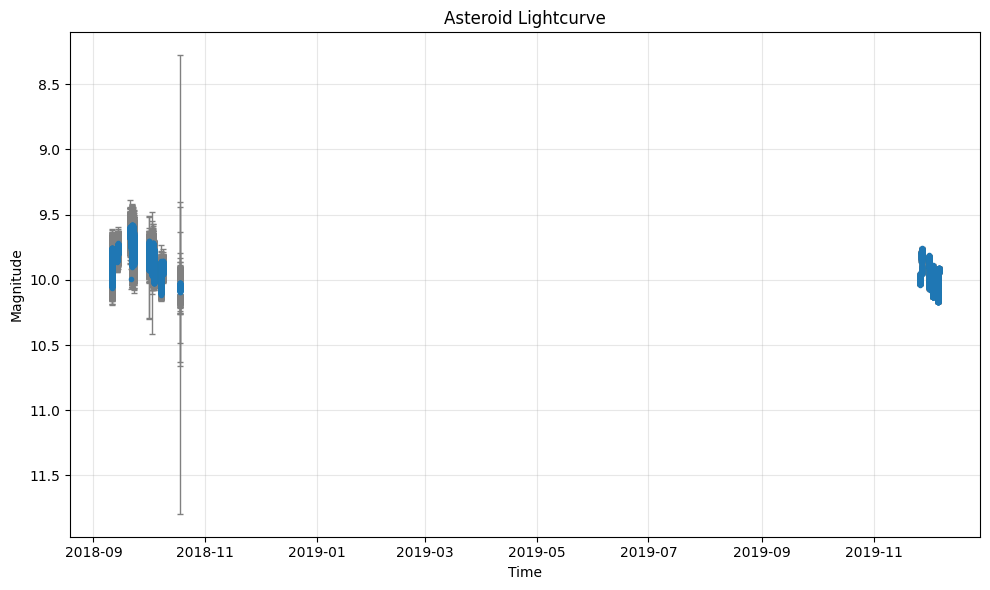

In [7]:
# Assuming the input file is named 'asteroid_data.txt'
Hygiea_file_path = "data/ALCDEF_10_Hygiea_20250329_174535.txt"

# Parse the data
t, y, errors = parse_asteroid_lightcurve(Hygiea_file_path)

# Print some basic statistics
print(f"Number of data points: {len(t)}")
print(f"Time range: {min(t)} to {max(t)}")
print(f"Magnitude range: {min(y)} to {max(y)}")


# Create a simple plot
plot_lightcurve(t,y,errors)


We can see there are two main periods of observation. One in late 2018 and another in late 2019. let's look at them independantly to see what happening a bit better.

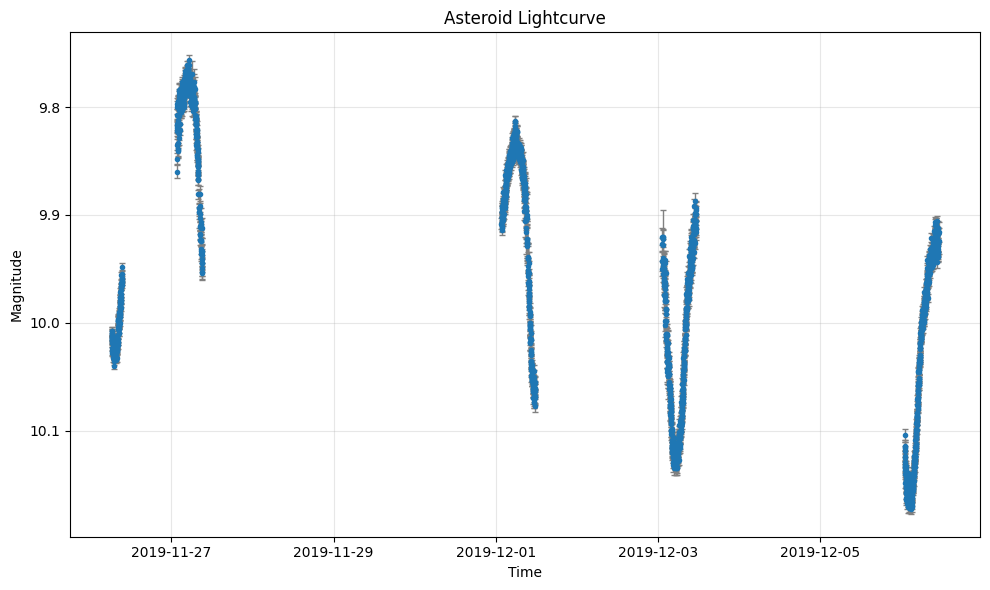

In [8]:
date = "2019-01"
slice_errors = errors[t > np.datetime64(date)]
slice_y = y[t > np.datetime64(date)]
slice_t = t[t > np.datetime64(date)]

plot_lightcurve(slice_t,slice_y,slice_errors)

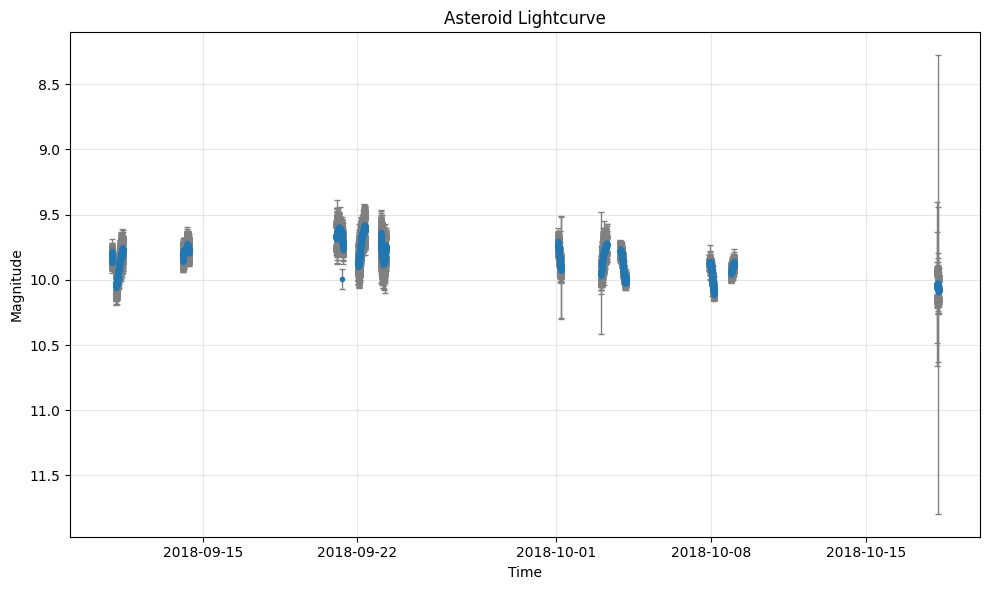

In [9]:
date = "2019-01"
slice_errors = errors[t < np.datetime64(date)]
slice_y = y[t < np.datetime64(date)]
slice_t = t[t < np.datetime64(date)]

plot_lightcurve(slice_t,slice_y,slice_errors)

Detected period: 49574.312637770396


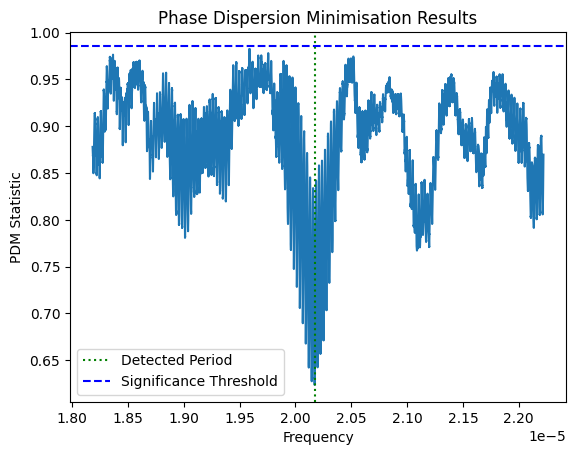

<Figure size 640x480 with 0 Axes>

In [73]:
min_freq = 1 / 55000

max_freq = 1 / 45000
n_bins = 100
n_freqs = int(1e5)
sig_theta = beta_test(len(t), n_bins, 0.00001)

freq, theta = pdm(t, y, min_freq, max_freq, n_freqs, n_bins, verbose=0)

sorted_indices = np.argsort(theta)
best_freq = freq[sorted_indices[0]]

print(f"Detected period: {1/best_freq}")

plt.figure()
plt.plot(freq, theta)
plt.axvline(best_freq, color="green", linestyle=":", label="Detected Period")

plt.axhline(sig_theta, color="blue", linestyle="--", label="Significance Threshold")
plt.xlabel("Frequency")
plt.ylabel("PDM Statistic")
plt.title("Phase Dispersion Minimisation Results")
plt.legend()
plt.show()
plt.savefig("outputs\theta_plot.png")

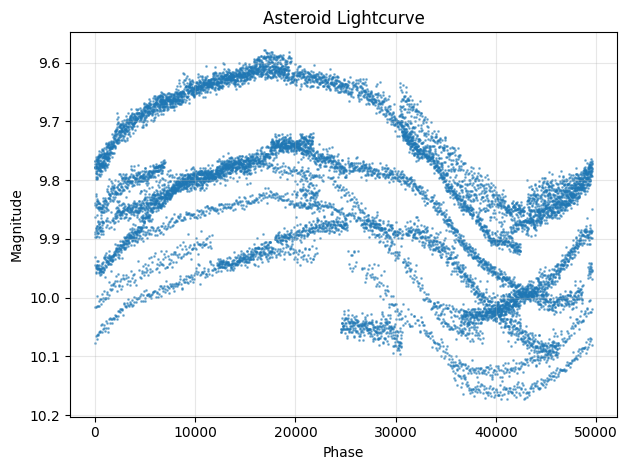

In [75]:
ns_timestamps = t.astype(np.int64)
# Convert nanoseconds to seconds (float)
seconds_array = ns_timestamps / 1e9
best_freq = freq[sorted_indices[2]]

plt.figure()
plt.scatter(seconds_array % (1 / (1 * best_freq)), y, alpha=0.5, s=1)
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.title("Asteroid Lightcurve")
plt.gca().invert_yaxis()  # Astronomical convention: brighter is lower
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("phase_plot.png")